## Introduction

In this notebook, I will convert addresses into their equivalent latitude and longitude values. Also, I will use the Foursquare API to explore neighborhoods in Toronto City. I will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will use the *k*-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the neighborhoods in Toronto City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

    1. <a href="#item1"><p>Build DataFrame with PostCode, Borough and Neighborhoods</p></a>

    2. <a href="#item2"><p>Extend DataFrame with Latitude and Longitude Data</p></a>

    3. <a href="#item3"><p>Explore and Analyze Each Neighborhood</p></a>

    4. <a href="#item4"><p>Cluster Neighborhoods</p></a>
    
    5. <a href="#item5"><p>Examine Clusters</p></a>
  
</font>
</div>

Firstly, import necessary libraries will be used

In [504]:
import urllib.request,re, os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import folium
import requests
import numpy as np
from sklearn.cluster import KMeans

## 1. Build DataFrame with PostCode, Borough and Neighborhoods
In this section, I will use BeautifulSoup to scrap data from the wiki page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M , then process the data into a DataFrame contain PostCode, Borough and Neighborhood of Toronto City

In [505]:
#Use BeautifulSoup to scrap data from the wiki page
# read the page content to the_page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req = urllib.request.Request(url)
with urllib.request.urlopen(req) as response:
     the_page = response.read()     
soup=BeautifulSoup(the_page,'html.parser')

#parse each table cells into list : lst_origin_data
lst_origin_data = []
table = soup.find('table', attrs={'class':'wikitable'})
table_body = table.find('tbody')
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    lst_origin_data.append([ele for ele in cols if ele]) # Get rid of empty values

#process the data with Not assigned value accordingly and store into dictionary with keys : dict_valid_data
dict_valid_data = dict()
for index,cell in enumerate(lst_origin_data):
    if cell:
        t_postcode=cell[0]
        t_borough=cell[1]
        t_neighborhood=cell[2]
        if not t_borough == "Not assigned":           #only process data with borough assigned
            if t_neighborhood == "Not assigned":      #assign borough to neighborhood if neighborhood is not assigned
                t_neighborhood = t_borough
            dict_valid_data.update({
                t_postcode:{
                    'Borough':t_borough,
                    'Neighborhood':(dict_valid_data[t_postcode]['Neighborhood']+
                                    ','+t_neighborhood 
                                    if t_postcode in dict_valid_data 
                                    else t_neighborhood)
                }})                                   #update neighborhood for multiple neighborhoods
            

print(len(dict_valid_data))
#conver the dictionary dict_valid_data to DataFrame: df
df=pd.DataFrame.from_dict(dict_valid_data,orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index':'PostCode'},inplace=True)
print(df.shape)
df.head()

103
(103, 3)


,PostCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


## 2. Extend DataFrame with Latitude and Longitude Data
In this section, because I'm not able to get the geographical coordinates of the neighborhoods using the Geocoder package, I use the link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data to extend the DataFrame with Latitude and Longitude data

In [506]:
#Get geosptical data from link, store as temp DataFrame: t_df_ll
t_df_ll=pd.read_csv('https://cocl.us/Geospatial_data')
#t_df_ll.head()

#Join LL information to df by Post Code, verify join result by M3A
#print(t_df_ll[t_df_ll['Postal Code']=='M3A'])
#print(df[df['PostCode']=='M3A'])
df=df.join(t_df_ll.set_index('Postal Code'), on='PostCode')
#print(df[df['PostCode']=='M3A'])
#df.head()

#Builde DataFrame as each row contains only one neighborhood : df_neighborhood_toronto 

#Iterate df, append seperate rows for borough with only one neighborhood in df_neighborhood_toronto
#move borough with multiple neighborhoods into df_tbd for further processing
df_neighborhood_toronto=pd.DataFrame(columns=['Neighborhood','Borough','PostCode','Latitude','Longitude'])
df_tbd=pd.DataFrame(columns=['Neighborhood','Borough','PostCode','Latitude','Longitude'])
for row in df.itertuples():
    t_postcode=row[1]
    t_borough=row[2]
    t_latitude=row[4]
    t_longitude=row[5]
    t_neighborhoods=row[3].split(',')
    if len(t_neighborhoods)>1:
        df_tbd=df_tbd.append({'Neighborhood':row[3],'Borough':t_borough,'PostCode':t_postcode,'Latitude':t_latitude,'Longitude':t_longitude},ignore_index=True)
    else:
        df_neighborhood_toronto=df_neighborhood_toronto.append({'Neighborhood':t_neighborhoods[0],'Borough':t_borough,'PostCode':t_postcode,'Latitude':t_latitude,'Longitude':t_longitude},ignore_index=True)

#Iterate df_tbd, append seperate rows for borough with multiple neighborhood, 
#and the <neighborhood,borough> still not exists in df_neighborhood_toronto
for row in df_tbd.itertuples():
    t_postcode=row[3]
    t_borough=row[2]
    t_latitude=row[4]
    t_longitude=row[5]
    t_neighborhoods=row[1].split(',')
    for t_neighborhood in t_neighborhoods:
        if df_neighborhood_toronto[(df_neighborhood_toronto['Neighborhood']==t_neighborhood) & (df_neighborhood_toronto['Borough']==t_borough) & (df_neighborhood_toronto['PostCode']==t_postcode)].empty:
            df_neighborhood_toronto=df_neighborhood_toronto.append({'Neighborhood':t_neighborhood,'Borough':t_borough,'PostCode':t_postcode,'Latitude':t_latitude,'Longitude':t_longitude},ignore_index=True)
        else:
            print(t_neighborhood,t_postcode,t_borough,t_latitude,t_longitude)
            print(df_neighborhood_toronto[df_neighborhood_toronto['Neighborhood']==t_neighborhood])

#Verify df_neighborhood_toronto contain seperate neighborhood correctly, 
df_neighborhood_toronto[df_neighborhood_toronto.groupby('Neighborhood')['Neighborhood'].transform('count')>1]


,Neighborhood,Borough,PostCode,Latitude,Longitude
3,Queen's Park,Downtown Toronto,M7A,43.662301,-79.389494
4,Queen's Park,Queen's Park,M9A,43.667856,-79.532242
8,St. James Town,Downtown Toronto,M5C,43.651494,-79.375418
130,Runnymede,York,M6N,43.673185,-79.487262
151,Runnymede,West Toronto,M6S,43.651571,-79.484450
191,St. James Town,Downtown Toronto,M4X,43.667967,-79.367675


Draw a map to visualize boroughs that contain the word Toronto.

In [507]:
#Select boroughs that contain the word Toronto from df_neighborhood_toronto
#and copy to new dataframe for explore and cluster : df_borough_toronto
df_borough_toronto=df_neighborhood_toronto[df_neighborhood_toronto['Borough'].str.contains('Toronto')].copy()
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_borough_toronto['Borough'].unique()),
        df_borough_toronto.shape[0]
    )
)
print(df_borough_toronto.shape)
df_borough_toronto.head()

#Get geograpical coordinate of Toronto City
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_borough_toronto['Latitude'], df_borough_toronto['Longitude'], df_borough_toronto['Borough'], df_borough_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The dataframe has 4 boroughs and 74 neighborhoods.
(74, 5)
The geograpical coordinate of Toronto City are 43.653963, -79.387207.


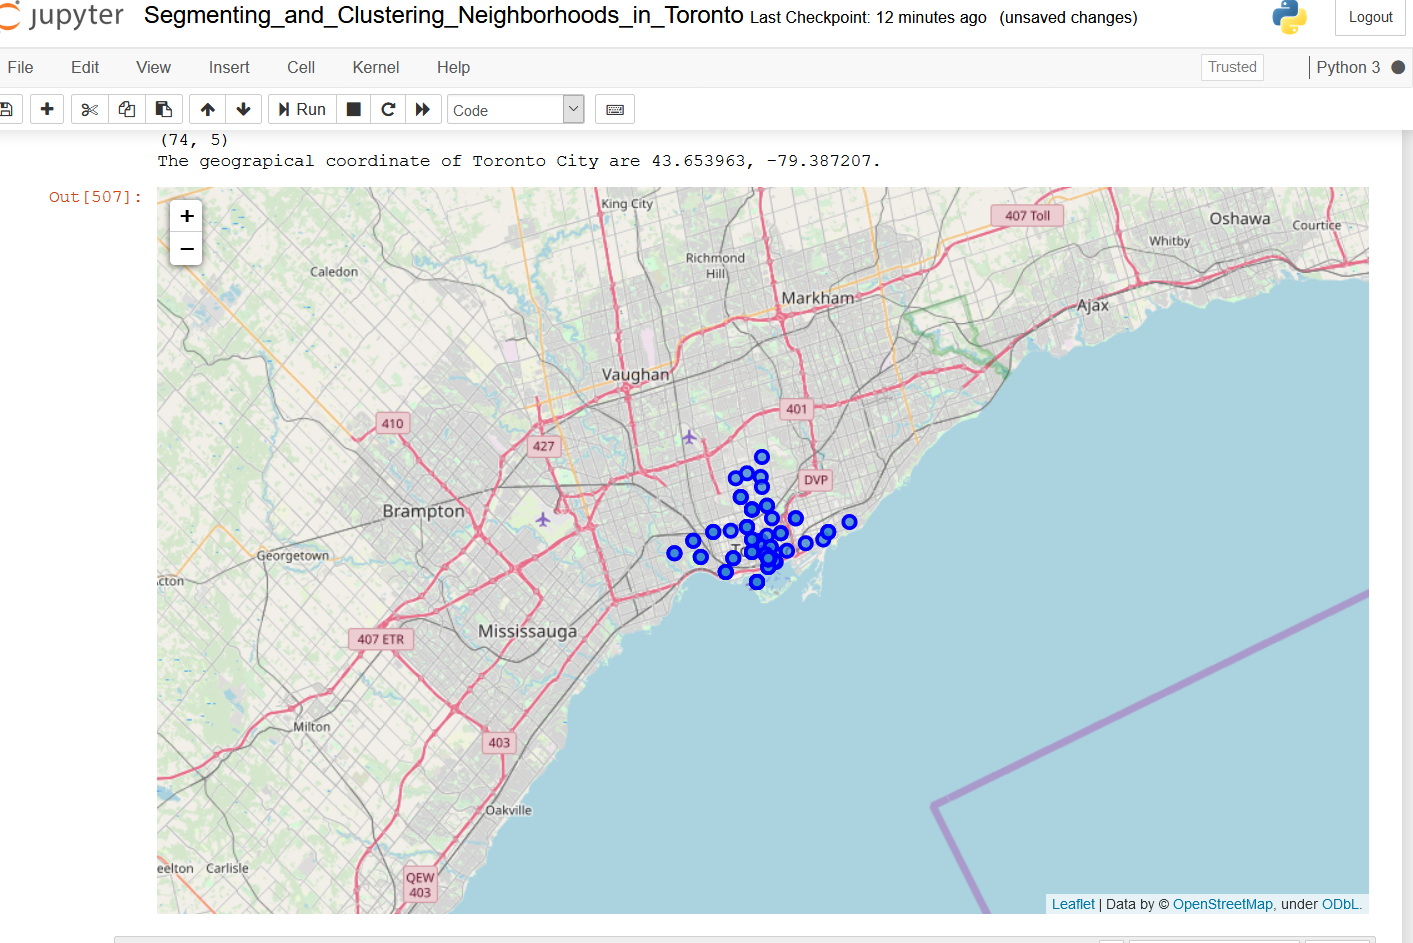

## 3. Explore and Analyze Each Neighborhood
In this section, I will use Foursquar API to explore near by venue data for neighborhoods whose boroughs that contain the word Toronto, print out Top 5 venues categories of each neighborhoods.
Then try to clustering these neighborhoods by frequency of Top 10 venue categories of each neighborhoods, with k-means clustering algorithm. Finally I will visualize the clustering result in a new map.

In [508]:
#Define access information for Foursquare API
CLIENT_ID = 'ME2333TV0LPPZQP4BJVWLSWHH5EQTERK0IIFRQ2INVTLUO4Z' # your Foursquare ID
CLIENT_SECRET = 'FEN4Y1CZX4YKB00BOPQVQZXB1ZJBTDBXRUUU3EDV35M33FGG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [509]:
#Define functions for retrieve and extract Nearby Venues from Foursquare
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    # function to repeat process venues data to all the neighborhoods 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        LIMIT=100
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [510]:
#Get Nearby Venues data for neighborhoods in df_borough_toronto from Foursquare,
#by LL information of the corresponding PostCode
#store into DataFrame : borough_toronto_venues
borough_toronto_venues = getNearbyVenues(names=df_borough_toronto['Neighborhood'],
                                   latitudes=df_borough_toronto['Latitude'],
                                   longitudes=df_borough_toronto['Longitude']
                                  )
print(borough_toronto_venues.shape)
borough_toronto_venues.groupby('Neighborhood')['Venue'].count()
print('There are {} uniques categories.'.format(len(borough_toronto_venues['Venue Category'].unique())))
borough_toronto_venues.head()

Harbourfront
Queen's Park
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Studio District
Lawrence Park
Roselawn
Davisville North
North Toronto West
Davisville
Rosedale
Stn A PO Boxes 25 The Esplanade
Church and Wellesley
Business Reply Mail Processing Centre 969 Eastern
Ryerson
Garden District
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
The Beaches West
India Bazaar
Commerce Court
Victoria Hotel
Forest Hill North
Forest Hill West
High Park
The Junction South
The Annex
North Midtown
Yorkville
Parkdale
Roncesvalles
Harbord
University of Toronto
Runnymede
Swansea
Moore Park
Summerhill East
Chinatown
Grange Park
Kensington Market
Deer Park
Forest Hill SE
Rathnelly
South Hill
Summerhill West
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South N

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [511]:
# one hot encoding
borough_toronto_onehot = pd.get_dummies(borough_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
borough_toronto_onehot['Neighborhood'] = borough_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns=list(borough_toronto_onehot.columns)
fixed_columns.pop(fixed_columns.index('Neighborhood'))
fixed_columns.insert(0,'Neighborhood')
borough_toronto_onehot=borough_toronto_onehot[fixed_columns]

print(borough_toronto_onehot.shape)
borough_toronto_onehot.head()
#borough_toronto_onehot['Neighborhood']

(3237, 240)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [512]:
borough_toronto_grouped = borough_toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(borough_toronto_grouped.shape)
borough_toronto_grouped.head()

(73, 240)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,...,0.0,0.0,0.020000,0.0,0.0,0.01,0.0,0.0,0.01,0.0
1,Bathurst Quay,0.0,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.017857,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,Brockton,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,Business Reply Mail Processing Centre 969 Eastern,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0


In [513]:
num_top_venues = 5

for hood in borough_toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = borough_toronto_grouped[borough_toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
             venue  freq
0      Coffee Shop  0.06
1  Thai Restaurant  0.04
2             Café  0.04
3              Bar  0.04
4   Cosmetics Shop  0.03


----Bathurst Quay----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3             Plane  0.06
4           Airport  0.06


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1            Beer Bar  0.04
2      Farmers Market  0.04
3   French Restaurant  0.04
4  Seafood Restaurant  0.04


----Brockton----
                venue  freq
0                Café  0.14
1      Breakfast Spot  0.09
2         Coffee Shop  0.09
3  Italian Restaurant  0.05
4             Stadium  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0                 Spa  0.07
1              Garden  0.07
2  Light Rail Station  0.07
3      Farmers Market  0.07
4       Auto Workshop  0.07


----CN Tower----
              venue  freq
0  

4               Bar  0.07


----Rosedale----
           venue  freq
0           Park  0.50
1     Playground  0.25
2          Trail  0.25
3   Noodle House  0.00
4  Metro Station  0.00


----Roselawn----
                venue  freq
0              Garden   0.5
1                Pool   0.5
2   Afghan Restaurant   0.0
3       Metro Station   0.0
4  Mexican Restaurant   0.0


----Runnymede----
                venue  freq
0         Pizza Place  0.08
1         Coffee Shop  0.08
2                Café  0.08
3    Sushi Restaurant  0.05
4  Italian Restaurant  0.05


----Ryerson----
                 venue  freq
0          Coffee Shop  0.08
1       Clothing Store  0.07
2                 Café  0.03
3  Japanese Restaurant  0.03
4       Cosmetics Shop  0.03


----South Hill----
                venue  freq
0                 Pub  0.14
1         Coffee Shop  0.14
2        Liquor Store  0.07
3  Light Rail Station  0.07
4    Sushi Restaurant  0.07


----South Niagara----
              venue  freq
0   Airport

## 4. Cluster Neighborhoods
In this section, I will clustering these neighborhoods by frequency of Top 10 venue categories of each neighborhoods, with k-means clustering algorithm. Finally I will visualize the clustering result in a new map.

In [514]:
#function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
#new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = borough_toronto_grouped['Neighborhood']

for ind in np.arange(borough_toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(borough_toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Thai Restaurant,Café,Bar,Restaurant,Steakhouse,Bakery,Burger Joint,Sushi Restaurant,Cosmetics Shop
1,Bathurst Quay,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane
2,Berczy Park,Coffee Shop,Beer Bar,French Restaurant,Café,Seafood Restaurant,Cheese Shop,Farmers Market,Cocktail Bar,Bakery,Steakhouse
3,Brockton,Café,Coffee Shop,Breakfast Spot,Grocery Store,Bakery,Pet Store,Convenience Store,Nightclub,Climbing Gym,Restaurant
4,Business Reply Mail Processing Centre 969 Eastern,Spa,Auto Workshop,Park,Pizza Place,Restaurant,Butcher,Burrito Place,Skate Park,Brewery,Farmers Market


In [515]:
#Run k-means to cluster the neighborhood into 5 clusters.
# set number of clusters
kclusters = 5

borough_toronto_grouped_clustering = borough_toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(borough_toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 0, 0, 0, 4, 0, 0, 0, 0])

In [516]:
#new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

borough_toronto_merged = df_borough_toronto

# merge neighborhood venuews data with df_borough_toronto to add latitude/longitude for each neighborhood
borough_toronto_merged = borough_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

borough_toronto_merged.head() # check the last columns!

,Neighborhood,Borough,PostCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Harbourfront,Downtown Toronto,M5A,43.654260,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Restaurant,Theater,Mexican Restaurant,Breakfast Spot,Café,Spa
3,Queen's Park,Downtown Toronto,M7A,43.662301,-79.389494,0,Coffee Shop,Gym,Park,Yoga Studio,Beer Bar,Chinese Restaurant,Diner,Bar,Mexican Restaurant,Italian Restaurant
8,St. James Town,Downtown Toronto,M5C,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Park,Bakery,American Restaurant,Italian Restaurant,Diner,Breakfast Spot,Clothing Store
10,The Beaches,East Toronto,M4E,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Other Great Outdoors,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
11,Berczy Park,Downtown Toronto,M5E,43.644771,-79.373306,0,Coffee Shop,Beer Bar,French Restaurant,Café,Seafood Restaurant,Cheese Shop,Farmers Market,Cocktail Bar,Bakery,Steakhouse


In [517]:
#visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(borough_toronto_merged['Latitude'], borough_toronto_merged['Longitude'], borough_toronto_merged['Neighborhood'], borough_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

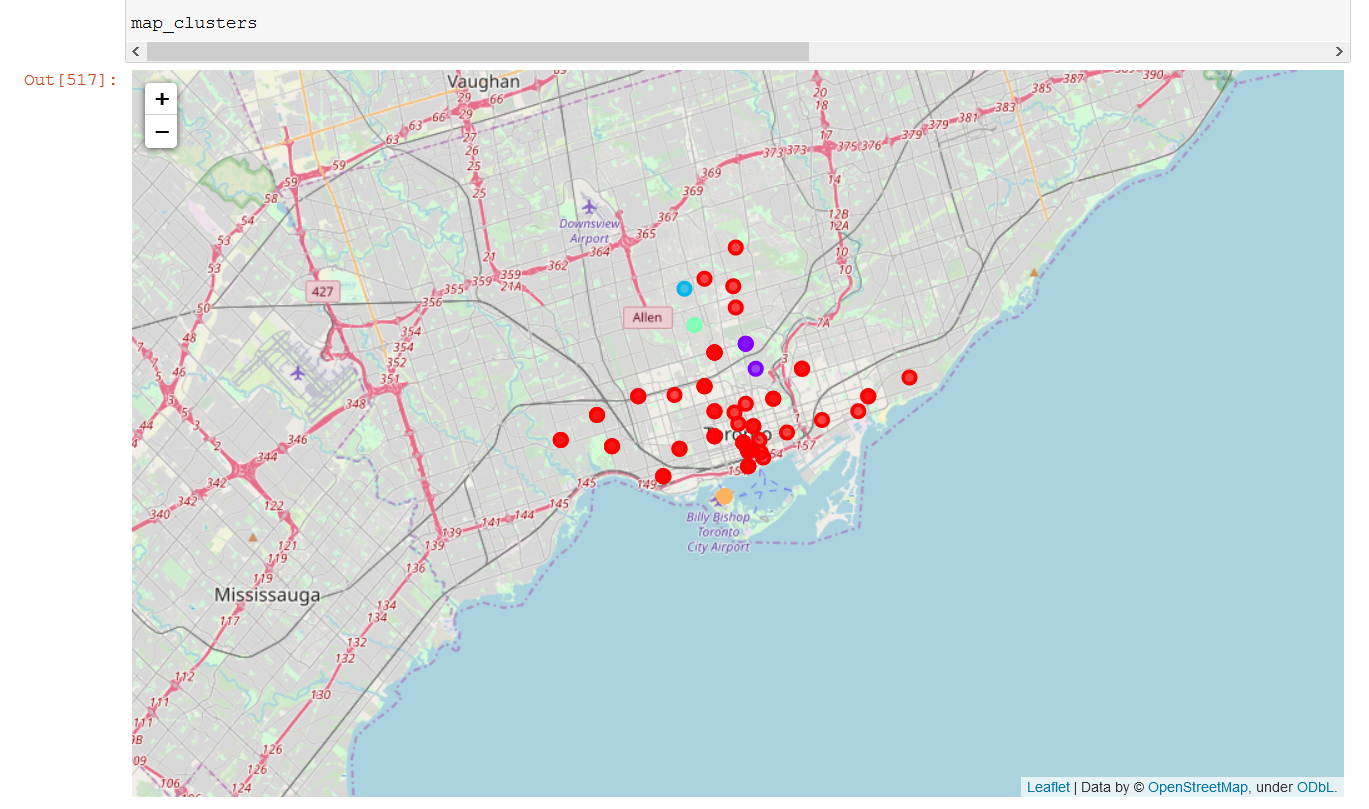

## 5. Examin Clusters
In this section, I will examin the 5 clustering neighborhoods.

In [518]:
#Summary of each cluster's 1st Most Common Venue
borough_toronto_merged.groupby('Cluster Labels')["1st Most Common Venue"].describe()

,count,unique,top,freq
Cluster Labels,,,,
0,61,16,Coffee Shop,24
1,3,2,Playground,2
2,1,1,Pool,1
3,2,1,Mexican Restaurant,2
4,7,1,Airport Service,7


In [519]:
#1st Cluster
borough_toronto_merged.loc[borough_toronto_merged['Cluster Labels'] == 0, borough_toronto_merged.columns[[1] + list(range(5, borough_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Bakery,Pub,Park,Restaurant,Theater,Mexican Restaurant,Breakfast Spot,Café,Spa
3,Downtown Toronto,0,Coffee Shop,Gym,Park,Yoga Studio,Beer Bar,Chinese Restaurant,Diner,Bar,Mexican Restaurant,Italian Restaurant
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Park,Bakery,American Restaurant,Italian Restaurant,Diner,Breakfast Spot,Clothing Store
10,East Toronto,0,Pub,Trail,Health Food Store,Other Great Outdoors,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
11,Downtown Toronto,0,Coffee Shop,Beer Bar,French Restaurant,Café,Seafood Restaurant,Cheese Shop,Farmers Market,Cocktail Bar,Bakery,Steakhouse
...,...,...,...,...,...,...,...,...,...,...,...,...
169,Central Toronto,0,Pub,Coffee Shop,Pizza Place,Light Rail Station,Sports Bar,Supermarket,Sushi Restaurant,Restaurant,Fried Chicken Joint,Liquor Store
190,Downtown Toronto,0,Park,Café,Restaurant,Coffee Shop,Italian Restaurant,Pub,Bakery,Pizza Place,Pet Store,Sandwich Place
191,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Park,Bakery,American Restaurant,Italian Restaurant,Diner,Breakfast Spot,Clothing Store
192,Downtown Toronto,0,Coffee Shop,Café,Steakhouse,Restaurant,Asian Restaurant,Bakery,Bar,American Restaurant,Hotel,Gastropub


In [520]:
#2nd Cluster
borough_toronto_merged.loc[borough_toronto_merged['Cluster Labels'] == 1, borough_toronto_merged.columns[[1] + list(range(5, borough_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Downtown Toronto,1,Park,Playground,Trail,Dessert Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
156,Central Toronto,1,Playground,Park,Restaurant,Tennis Court,Concert Hall,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
157,Central Toronto,1,Playground,Park,Restaurant,Tennis Court,Concert Hall,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [521]:
#3rd Cluster
borough_toronto_merged.loc[borough_toronto_merged['Cluster Labels'] == 2, borough_toronto_merged.columns[[1] + list(range(5, borough_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Central Toronto,2,Pool,Garden,Yoga Studio,Dessert Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [522]:
#4th Cluster
borough_toronto_merged.loc[borough_toronto_merged['Cluster Labels'] == 3, borough_toronto_merged.columns[[1] + list(range(5, borough_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
134,Central Toronto,3,Mexican Restaurant,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
135,Central Toronto,3,Mexican Restaurant,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [523]:
#5th Cluster
borough_toronto_merged.loc[borough_toronto_merged['Cluster Labels'] == 4, borough_toronto_merged.columns[[1] + list(range(5, borough_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
170,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane
171,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane
172,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane
173,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane
174,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane
175,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane
176,Downtown Toronto,4,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boutique,Rental Car Location,Coffee Shop,Boat or Ferry,Sculpture Garden,Plane


In [524]:
borough_toronto_merged.loc[borough_toronto_merged['Cluster Labels'] == 5, borough_toronto_merged.columns[[1] + list(range(5, borough_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [ ]:
#Builde DataFrame as each row contains only one neighborhood : df_neighborhood_toronto 

#Iterate df, append seperate rows for borough with only one neighborhood in df_neighborhood_toronto
#move borough with multiple neighborhoods into df_tbd for further processing
df_neighborhood_toronto=pd.DataFrame(columns=['Neighborhood','Borough','PostCode','Latitude','Longitude'])
df_tbd=pd.DataFrame(columns=['Neighborhood','Borough','PostCode','Latitude','Longitude'])
for row in df.itertuples():
    t_postcode=row[1]
    t_borough=row[2]
    t_latitude=row[4]
    t_longitude=row[5]
    t_neighborhoods=row[3].split(',')
    if len(t_neighborhoods)>1:
        df_tbd=df_tbd.append({'Neighborhood':row[3],'Borough':t_borough,'PostCode':t_postcode,'Latitude':t_latitude,'Longitude':t_longitude},ignore_index=True)
    else:
        df_neighborhood_toronto=df_neighborhood_toronto.append({'Neighborhood':t_neighborhoods[0],'Borough':t_borough,'PostCode':t_postcode,'Latitude':t_latitude,'Longitude':t_longitude},ignore_index=True)

#Iterate df_tbd, append seperate rows for borough with multiple neighborhood, 
#and the <neighborhood,borough> still not exists in df_neighborhood_toronto
for row in df_tbd.itertuples():
    t_postcode=row[3]
    t_borough=row[2]
    t_latitude=row[4]
    t_longitude=row[5]
    t_neighborhoods=row[1].split(',')
    for t_neighborhood in t_neighborhoods:
        if df_neighborhood_toronto[(df_neighborhood_toronto['Neighborhood']==t_neighborhood) & (df_neighborhood_toronto['Borough']==t_borough) & (df_neighborhood_toronto['PostCode']==t_postcode)].empty:
            df_neighborhood_toronto=df_neighborhood_toronto.append({'Neighborhood':t_neighborhood,'Borough':t_borough,'PostCode':t_postcode,'Latitude':t_latitude,'Longitude':t_longitude},ignore_index=True)
        else:
            print(t_neighborhood,t_postcode,t_borough,t_latitude,t_longitude)
            print(df_neighborhood_toronto[df_neighborhood_toronto['Neighborhood']==t_neighborhood])

#Verify df_neighborhood_toronto contain seperate neighborhood correctly, 
df_neighborhood_toronto[df_neighborhood_toronto.groupby('Neighborhood')['Neighborhood'].transform('count')>1]

#Verify df_neighborhood_toronto contain seperate neighborhood correctly, 
df_neighborhood_toronto[df_neighborhood_toronto.groupby('Neighborhood')['Neighborhood'].transform('count')>1]

#Retrieve geodata information from arcgis by geocoder
import geocoder
#g = geocoder.bing('East Toronto, Toronto,Ontario')
for row in df_borough_toronto.itertuples():
    g = geocoder.arcgis(row[1]+','+row[2]+',Toronto,Ontario,CA')
    print(row[1],g.geojson)
borough_toronto_venues[borough_toronto_venues['Venue']=='Starbucks'].groupby(['Venue Latitude','Venue Longitude']).count()

Harbourfront {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Harbourfront Centre', 'bbox': [-79.38806999999997, 43.63423000000005, -79.37806999999998, 43.64423000000006], 'confidence': 7, 'lat': 43.63950995556605, 'lng': -79.38315993782102, 'ok': True, 'quality': 'POI', 'raw': {'name': 'Harbourfront Centre', 'extent': {'xmin': -79.38806999999997, 'ymin': 43.63423000000005, 'xmax': -79.37806999999998, 'ymax': 43.64423000000006}, 'feature': {'geometry': {'x': -79.38315993782102, 'y': 43.63950995556605}, 'attributes': {'Score': 85.42, 'Addr_Type': 'POI'}}}, 'score': 85.42, 'status': 'OK'}, 'bbox': [-79.38806999999997, 43.63423000000005, -79.37806999999998, 43.64423000000006], 'geometry': {'type': 'Point', 'coordinates': [-79.38315993782102, 43.63950995556605]}}]}
Queen's Park {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': "Queen's Park, Toronto, Ontario, M7A", 'bbox': [-79.3918495, 43.6596698965822, -79.38

Davisville North {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Davisville, Toronto, Ontario', 'bbox': [-79.39351999999998, 43.69175000000006, -79.37351999999997, 43.71175000000006], 'confidence': 7, 'lat': 43.70175000000006, 'lng': -79.38351999999998, 'ok': True, 'quality': 'Locality', 'raw': {'name': 'Davisville, Toronto, Ontario', 'extent': {'xmin': -79.39351999999998, 'ymin': 43.69175000000006, 'xmax': -79.37351999999997, 'ymax': 43.71175000000006}, 'feature': {'geometry': {'x': -79.38351999999998, 'y': 43.70175000000006}, 'attributes': {'Score': 89.33, 'Addr_Type': 'Locality'}}}, 'score': 89.33, 'status': 'OK'}, 'bbox': [-79.39351999999998, 43.69175000000006, -79.37351999999997, 43.71175000000006], 'geometry': {'type': 'Point', 'coordinates': [-79.38351999999998, 43.70175000000006]}}]}
North Toronto West {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'North Toronto, Toronto, Ontario', 'bbox': [-79

King {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Downtown Ford', 'bbox': [-79.36280999999997, 43.650380000000034, -79.35280999999998, 43.66038000000004], 'confidence': 7, 'lat': 43.655699937244165, 'lng': -79.35807998110118, 'ok': True, 'quality': 'POI', 'raw': {'name': 'Downtown Ford', 'extent': {'xmin': -79.36280999999997, 'ymin': 43.650380000000034, 'xmax': -79.35280999999998, 'ymax': 43.66038000000004}, 'feature': {'geometry': {'x': -79.35807998110118, 'y': 43.655699937244165}, 'attributes': {'Score': 93.03, 'Addr_Type': 'POI'}}}, 'score': 93.03, 'status': 'OK'}, 'bbox': [-79.36280999999997, 43.650380000000034, -79.35280999999998, 43.66038000000004], 'geometry': {'type': 'Point', 'coordinates': [-79.35807998110118, 43.655699937244165]}}]}
Richmond {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Richmond St W, Toronto, Ontario, M5H', 'bbox': [-79.38404878409851, 43.649777143180295, -79.3820487840

Riverdale {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Riverdale Dr, Etobicoke, Toronto, Ontario, M9V 2T2', 'bbox': [-79.56098323768029, 43.73115138411897, -79.55898323768028, 43.73315138411896], 'confidence': 9, 'lat': 43.732151384118964, 'lng': -79.55998323768029, 'ok': True, 'quality': 'StreetName', 'raw': {'name': 'Riverdale Dr, Etobicoke, Toronto, Ontario, M9V 2T2', 'extent': {'xmin': -79.56098323768029, 'ymin': 43.73115138411897, 'xmax': -79.55898323768028, 'ymax': 43.73315138411896}, 'feature': {'geometry': {'x': -79.55998323768029, 'y': 43.732151384118964}, 'attributes': {'Score': 97.81, 'Addr_Type': 'StreetName'}}}, 'score': 97.81, 'status': 'OK'}, 'bbox': [-79.56098323768029, 43.73115138411897, -79.55898323768028, 43.73315138411896], 'geometry': {'type': 'Point', 'coordinates': [-79.55998323768029, 43.732151384118964]}}]}
Design Exchange {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Desig

Forest Hill North {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Forest Hill North, Toronto, Ontario', 'bbox': [-79.43844999999996, 43.69422000000005, -79.41644999999997, 43.71622000000006], 'confidence': 7, 'lat': 43.705220000000054, 'lng': -79.42744999999996, 'ok': True, 'quality': 'Locality', 'raw': {'name': 'Forest Hill North, Toronto, Ontario', 'extent': {'xmin': -79.43844999999996, 'ymin': 43.69422000000005, 'xmax': -79.41644999999997, 'ymax': 43.71622000000006}, 'feature': {'geometry': {'x': -79.42744999999996, 'y': 43.705220000000054}, 'attributes': {'Score': 93.78, 'Addr_Type': 'Locality'}}}, 'score': 93.78, 'status': 'OK'}, 'bbox': [-79.43844999999996, 43.69422000000005, -79.41644999999997, 43.71622000000006], 'geometry': {'type': 'Point', 'coordinates': [-79.42744999999996, 43.705220000000054]}}]}
Forest Hill West {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Forest Hill, York, Toronto, On

University of Toronto {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'University of Toronto', 'bbox': [-79.40751999999996, 43.65845000000003, -79.38951999999996, 43.67645000000003], 'confidence': 7, 'lat': 43.66774998831461, 'lng': -79.39863994503438, 'ok': True, 'quality': 'POI', 'raw': {'name': 'University of Toronto', 'extent': {'xmin': -79.40751999999996, 'ymin': 43.65845000000003, 'xmax': -79.38951999999996, 'ymax': 43.67645000000003}, 'feature': {'geometry': {'x': -79.39863994503438, 'y': 43.66774998831461}, 'attributes': {'Score': 90.4, 'Addr_Type': 'POI'}}}, 'score': 90.4, 'status': 'OK'}, 'bbox': [-79.40751999999996, 43.65845000000003, -79.38951999999996, 43.67645000000003], 'geometry': {'type': 'Point', 'coordinates': [-79.39863994503438, 43.66774998831461]}}]}
Runnymede {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'address': 'Runnymede Rd, York, Toronto, Ontario, M6N', 'bbox': [-79.48467962384773, 43.